<a href="https://colab.research.google.com/github/Abu-shanto/Machine-Learning-/blob/main/InceptionV3_and_Decision_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
pip install tensorflow numpy pandas matplotlib


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split

# Step 1: Data Collection and Preprocessing

# Path to the folder containing MRI images
data_dir = "/content/drive/MyDrive/brain_tumor_dataset train"

# List of classes (subfolders in data_dir)
classes = ["/content/drive/MyDrive/brain_tumor_dataset train/yes", "/content/drive/MyDrive/brain_tumor_dataset train/no"]

# Initialize lists to store the image data and corresponding labels
images = []
labels = []

# Iterate through the classes to load and preprocess the images
for class_index, class_name in enumerate(classes):
    class_dir = os.path.join(data_dir, class_name)
    for image_filename in os.listdir(class_dir):
        # Load the image using TensorFlow's img_to_array function
        img = load_img(os.path.join(class_dir, image_filename), target_size=(224, 224))
        img = img_to_array(img)

        # Normalize pixel values to a range of [0, 1]
        img = img / 255.0

        # Append the preprocessed image and label to their respective lists
        images.append(img)
        labels.append(class_index)  # Use class_index as the label (0 for tumor, 1 for non-tumor)

# Convert the lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Split the data into training and testing sets (80% training, 20% testing)
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

# Verify the data shape
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Testing images shape:", test_images.shape)
print("Testing labels shape:", test_labels.shape)


Training images shape: (202, 224, 224, 3)
Training labels shape: (202,)
Testing images shape: (51, 224, 224, 3)
Testing labels shape: (51,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Step 2: Feature Extraction with InceptionV3

# Load the pre-trained InceptionV3 model (without top classification layers)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add a GlobalAveragePooling2D layer to reduce the spatial dimensions of the output
x = GlobalAveragePooling2D()(base_model.output)

# Create a new model with InceptionV3 base and GlobalAveragePooling2D layer
model = Model(inputs=base_model.input, outputs=x)

# Print the model summary to check the architecture
model.summary()


87910968/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                  

In [ ]:
# Step 3: Data Preparation for Decision Tree

# Flatten the extracted features from each MRI image
def flatten_features(features):
    return features.reshape(features.shape[0], -1)

# Flatten the training and testing features
train_features = flatten_features(model.predict(train_images))
test_features = flatten_features(model.predict(test_images))

# Verify the shape of the flattened features
print("Flattened Training Features shape:", train_features.shape)
print("Flattened Testing Features shape:", test_features.shape)

# Combine the feature vectors with their corresponding labels
train_data = (train_features, train_labels)
test_data = (test_features, test_labels)


2/2 [==============================] - 4s 1s/step
Flattened Training Features shape: (202, 2048)
Flattened Testing Features shape: (51, 2048)


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Step 4: Decision Tree Training

# Create and train the Decision Tree classifier
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(train_data[0], train_data[1])

# Step 5: Model Evaluation

# Make predictions on the testing data
y_pred = decision_tree.predict(test_data[0])

# Calculate evaluation metrics
accuracy = accuracy_score(test_data[1], y_pred)
precision = precision_score(test_data[1], y_pred)
recall = recall_score(test_data[1], y_pred)
f1 = f1_score(test_data[1], y_pred)
conf_matrix = confusion_matrix(test_data[1], y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.7254901960784313
Precision: 0.7083333333333334
Recall: 0.7083333333333334
F1 Score: 0.7083333333333334
Confusion Matrix:
 [[20  7]
 [ 7 17]]


In [ ]:
from sklearn.model_selection import GridSearchCV

# Step 6: Hyperparameter Tuning

# Define the hyperparameters and their respective values to search
param_grid = {
    'max_depth': [None, 10, 20, 30],  # You can customize the values to explore
    'min_samples_split': [2, 5, 10],  # You can customize the values to explore
    'min_samples_leaf': [1, 2, 4]     # You can customize the values to explore
}

# Create the Decision Tree classifier
decision_tree = DecisionTreeClassifier(random_state=42)

# Perform grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(decision_tree, param_grid, cv=5, scoring='accuracy')
grid_search.fit(train_data[0], train_data[1])

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the Decision Tree classifier with the best hyperparameters
best_decision_tree = DecisionTreeClassifier(random_state=42, **best_params)
best_decision_tree.fit(train_data[0], train_data[1])

# Step 5: Model Evaluation (using the best model)

# Make predictions on the testing data using the best model
y_pred = best_decision_tree.predict(test_data[0])

# Calculate evaluation metrics
accuracy = accuracy_score(test_data[1], y_pred)
precision = precision_score(test_data[1], y_pred)
recall = recall_score(test_data[1], y_pred)
f1 = f1_score(test_data[1], y_pred)
conf_matrix = confusion_matrix(test_data[1], y_pred)

# Print the evaluation metrics for the best model
print("Best Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)



Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best Model Evaluation Metrics:
Accuracy: 0.7450980392156863
Precision: 0.7391304347826086
Recall: 0.7083333333333334
F1 Score: 0.723404255319149
Confusion Matrix:
 [[21  6]
 [ 7 17]]


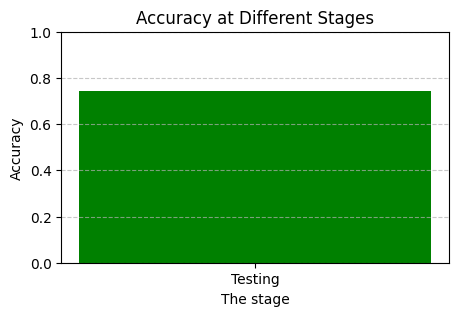

In [ ]:
import matplotlib.pyplot as plt

test_accuracy = 0.7450980392156863

# Create data for the accuracy graph
stages = ['Testing']
accuracies = [test_accuracy]

# Plot the accuracy graph
plt.figure(figsize=(5, 3))
plt.bar(stages, accuracies, color=['green'])
plt.xlabel('The stage')
plt.ylabel('Accuracy')
plt.ylim(0.0, 1.0)
plt.title('Accuracy at Different Stages')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

